In [1]:
# System libs
import os
import time
import argparse
from distutils.version import LooseVersion
# Numerical libs
import numpy as np
import torch
import torch.nn as nn
from scipy.io import loadmat
# Our libs
from mit_semseg.config import cfg
from mit_semseg.dataset import ValDataset
from mit_semseg.models import ModelBuilder, SegmentationModule
from mit_semseg.utils import AverageMeter, colorEncode, accuracy, intersectionAndUnion, setup_logger
from mit_semseg.lib.nn import user_scattered_collate, async_copy_to
from mit_semseg.lib.utils import as_numpy
from PIL import Image
from tqdm import tqdm

import os, csv, torch, numpy, scipy.io, PIL.Image, torchvision.transforms

In [2]:
colors = loadmat('data/color150.mat')['colors']


def visualize_result(data, pred, dir_result):
    (img, seg, info) = data

    # segmentation
    seg_color = colorEncode(seg, colors)

    # prediction
    pred_color = colorEncode(pred, colors)

    # aggregate images and save
    im_vis = np.concatenate((img, seg_color, pred_color),
                            axis=1).astype(np.uint8)

    img_name = info.split('/')[-1]
    Image.fromarray(im_vis).save(os.path.join(dir_result, img_name.replace('.jpg', '.png')))


def evaluate(segmentation_module, loader, cfg, gpu):
    acc_meter = AverageMeter()
    intersection_meter = AverageMeter()
    union_meter = AverageMeter()
    time_meter = AverageMeter()

    segmentation_module.eval()

    pbar = tqdm(total=len(loader))
    for batch_data in loader:
        # process data
        batch_data = batch_data[0]
        seg_label = as_numpy(batch_data['seg_label'][0])
        img_resized_list = batch_data['img_data']

        torch.cuda.synchronize()
        tic = time.perf_counter()
        with torch.no_grad():
            segSize = (seg_label.shape[0], seg_label.shape[1])
            scores = torch.zeros(1, cfg.DATASET.num_class, segSize[0], segSize[1])
            scores = async_copy_to(scores, gpu)

            for img in img_resized_list:
                feed_dict = batch_data.copy()
                feed_dict['img_data'] = img
                del feed_dict['img_ori']
                del feed_dict['info']
                feed_dict = async_copy_to(feed_dict, gpu)

                # forward pass
                scores_tmp = segmentation_module(feed_dict, segSize=segSize)
                scores = scores + scores_tmp / len(cfg.DATASET.imgSizes)

            _, pred = torch.max(scores, dim=1)
            pred = as_numpy(pred.squeeze(0).cpu())

        torch.cuda.synchronize()
        time_meter.update(time.perf_counter() - tic)

        # calculate accuracy
        acc, pix = accuracy(pred, seg_label)
        intersection, union = intersectionAndUnion(pred, seg_label, cfg.DATASET.num_class)
        acc_meter.update(acc, pix)
        intersection_meter.update(intersection)
        union_meter.update(union)

        # visualization
        if cfg.VAL.visualize:
            visualize_result(
                (batch_data['img_ori'], seg_label, batch_data['info']),
                pred,
                os.path.join(cfg.DIR, 'result')
            )

        pbar.update(1)

    # summary
    iou = intersection_meter.sum / (union_meter.sum + 1e-10)
    for i, _iou in enumerate(iou):
        #print('class [{}], IoU: {:.4f}'.format(i, _iou))
        pass

    #print('[Eval Summary]:')
    #print('Mean IoU: {:.4f}, Accuracy: {:.2f}%, Inference Time: {:.4f}s'
    #      .format(iou.mean(), acc_meter.average()*100, time_meter.average()))
    
    return pred, acc_meter.average()*100


def main(cfg, gpu):
    torch.cuda.set_device(gpu)

    # Network Builders
    net_encoder = ModelBuilder.build_encoder(
        arch=cfg.MODEL.arch_encoder.lower(),
        fc_dim=cfg.MODEL.fc_dim,
        weights=cfg.MODEL.weights_encoder)
    net_decoder = ModelBuilder.build_decoder(
        arch=cfg.MODEL.arch_decoder.lower(),
        fc_dim=cfg.MODEL.fc_dim,
        num_class=cfg.DATASET.num_class,
        weights=cfg.MODEL.weights_decoder,
        use_softmax=True)

    crit = nn.NLLLoss(ignore_index=-1)

    segmentation_module = SegmentationModule(net_encoder, net_decoder, crit)

    # Dataset and Loader
    dataset_val = ValDataset(
        cfg.DATASET.root_dataset,
        cfg.DATASET.list_val,
        cfg.DATASET)
    loader_val = torch.utils.data.DataLoader(
        dataset_val,
        batch_size=cfg.VAL.batch_size,
        shuffle=False,
        collate_fn=user_scattered_collate,
        num_workers=5,
        drop_last=True)

    segmentation_module.cuda()

    # Main loop
    evaluate(segmentation_module, loader_val, cfg, gpu)

    print('Evaluation Done!')

'''
if __name__ == '__main__':
    assert LooseVersion(torch.__version__) >= LooseVersion('0.4.0'), \
        'PyTorch>=0.4.0 is required'

    parser = argparse.ArgumentParser(
        description="PyTorch Semantic Segmentation Validation"
    )
    parser.add_argument(
        "--cfg",
        default="config/ade20k-resnet50dilated-ppm_deepsup.yaml",
        metavar="FILE",
        help="path to config file",
        type=str,
    )
    parser.add_argument(
        "--gpu",
        default=0,
        help="gpu to use"
    )
    parser.add_argument(
        "opts",
        help="Modify config options using the command-line",
        default=None,
        nargs=argparse.REMAINDER,
    )
    args = parser.parse_args()

    cfg.merge_from_file(args.cfg)
    cfg.merge_from_list(args.opts)
    # cfg.freeze()

    logger = setup_logger(distributed_rank=0)   # TODO
    logger.info("Loaded configuration file {}".format(args.cfg))
    logger.info("Running with config:\n{}".format(cfg))

    # absolute paths of model weights
    cfg.MODEL.weights_encoder = os.path.join(
        cfg.DIR, 'encoder_' + cfg.VAL.checkpoint)
    cfg.MODEL.weights_decoder = os.path.join(
        cfg.DIR, 'decoder_' + cfg.VAL.checkpoint)
    assert os.path.exists(cfg.MODEL.weights_encoder) and \
        os.path.exists(cfg.MODEL.weights_decoder), "checkpoint does not exitst!"

    if not os.path.isdir(os.path.join(cfg.DIR, "result")):
        os.makedirs(os.path.join(cfg.DIR, "result"))

    main(cfg, args.gpu)
'''
print()

In [3]:
config_path = "config/ade20k-resnet50dilated-ppm_deepsup.yaml"
gpu = 0
opts = None

cfg.merge_from_file(config_path)
# cfg.merge_from_list(opts)

# absolute paths of model weights
cfg.MODEL.weights_encoder = os.path.join(
    cfg.DIR, 'encoder_' + cfg.VAL.checkpoint)
cfg.MODEL.weights_decoder = os.path.join(
    cfg.DIR, 'decoder_' + cfg.VAL.checkpoint)
assert os.path.exists(cfg.MODEL.weights_encoder) and \
    os.path.exists(cfg.MODEL.weights_decoder), "checkpoint does not exitst!"

In [113]:
torch.cuda.set_device(gpu)

# Network Builders
net_encoder = ModelBuilder.build_encoder(
    arch=cfg.MODEL.arch_encoder.lower(),
    fc_dim=cfg.MODEL.fc_dim,
    weights=cfg.MODEL.weights_encoder)
net_decoder = ModelBuilder.build_decoder(
    arch=cfg.MODEL.arch_decoder.lower(),
    fc_dim=cfg.MODEL.fc_dim,
    num_class=cfg.DATASET.num_class,
    weights=cfg.MODEL.weights_decoder,
    use_softmax=True)

crit = nn.NLLLoss(ignore_index=-1)

segmentation_module = SegmentationModule(net_encoder, net_decoder, crit)

Loading weights for net_encoder
Loading weights for net_decoder


In [114]:
cfg.DATASET.list_val

'./data/validation.odgt'

In [115]:
img_path = "/home/zyang/Documents/fork_sseg_mit/notebooks/data/ADEChallengeData2016/images/training/ADE_train_00000001.jpg"
anno_path = "/home/zyang/Documents/fork_sseg_mit/notebooks/data/ADEChallengeData2016/annotations/training/ADE_train_00000001.png"

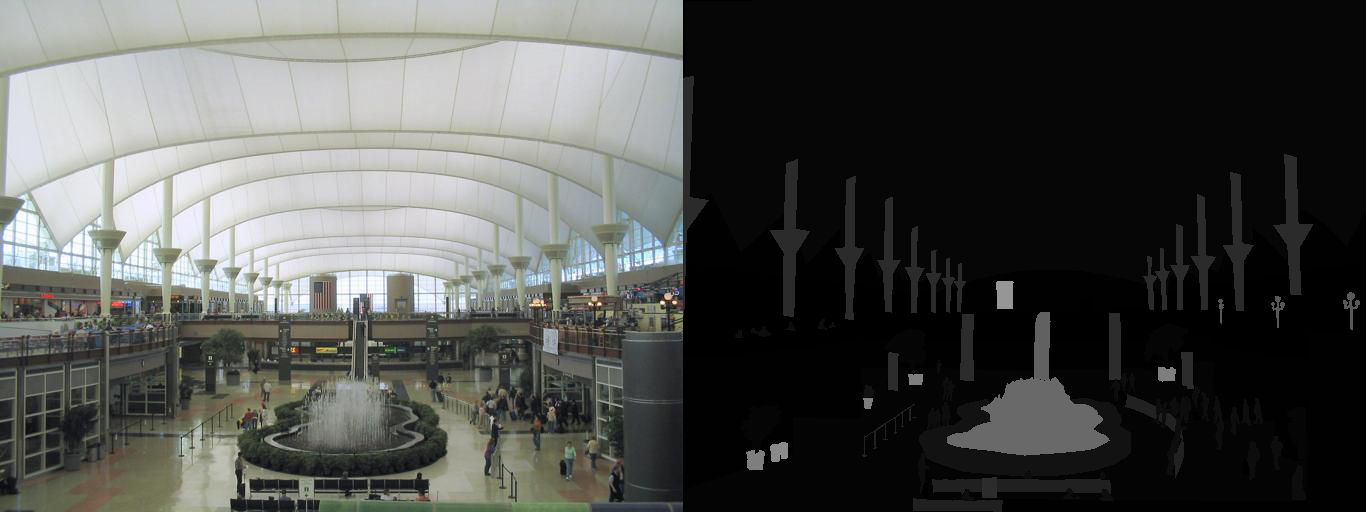

In [126]:
img = PIL.Image.open(img_path).convert('RGB')
anno_rgb = PIL.Image.open(anno_path).convert('RGB')

anno = PIL.Image.open(anno_path)
anno = np.array(anno)
anno[np.where(anno!=0)]-=1

width = img.size[0]
height = img.size[1]

im_vis = numpy.concatenate((img, anno_rgb), axis=1)
display(PIL.Image.fromarray(im_vis))

In [148]:
def create_tmp_obgt(img_path, anno_path):
    # create a tmp obgt file for 1 img
    eval_img = "{\"fpath_img\": " + "\"{}\", ".format(img_path) + "\"fpath_segm\": " + "\"{}\", ".format(anno_path) + \
                "\"width\": " + str(width) + ", \"height\": " + str(height) + "}"

    # {"fpath_img": "img", "fpath_segm": "ano", "width": 683, "height": 512}
    f = open("tmp_eval.odgt", "w")
    f.write("{}".format(eval_img))
    f.close()

In [149]:
create_tmp_obgt(img_path, anno_path)

In [128]:
# Dataset and Loader
dataset_val = ValDataset("", "tmp_eval.odgt", cfg.DATASET)
loader_val = torch.utils.data.DataLoader(
    dataset_val,
    batch_size=1,
    shuffle=False,
    collate_fn=user_scattered_collate,
    num_workers=1,
    drop_last=True)

# samples: 1


In [129]:
segmentation_module.cuda()

# Main loop
pred, acc = evaluate(segmentation_module, loader_val, cfg, gpu)
print(acc)


100%|██████████| 1/1 [00:00<00:00,  1.29it/s]

90.93313963631054


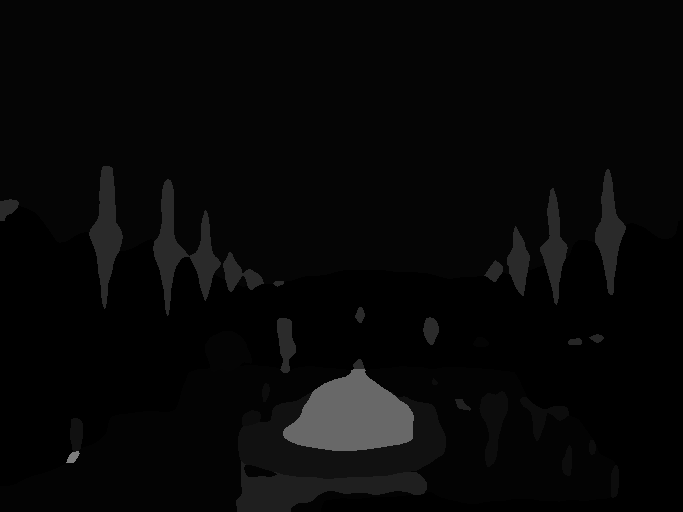

In [130]:
display(PIL.Image.fromarray(pred.astype(np.uint8)))

In [131]:
# # classes for pred
len(np.unique(pred))

13

In [132]:
len(np.unique(anno))

16

In [133]:
# System libs
import os, csv, torch, numpy, scipy.io, PIL.Image, torchvision.transforms
# Our libs
from mit_semseg.models import ModelBuilder, SegmentationModule
from mit_semseg.utils import colorEncode

colors = scipy.io.loadmat('data/color150.mat')['colors']
names = {}
with open('data/object150_info.csv') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        names[int(row[0])] = row[5].split(";")[0]

def visualize_result(img, pred, index=None, show=True):
    # filter prediction class if requested
    if index is not None:
        pred = pred.copy()
        pred[pred != index] = -1
        print(f'{names[index+1]}:')
        
    # colorize prediction
    pred_color = colorEncode(pred, colors).astype(numpy.uint8)

    # aggregate images and save
    im_vis = numpy.concatenate((img, pred_color), axis=1)
    if show==True:
        display(PIL.Image.fromarray(im_vis))
    else:
        return pred_color, im_vis

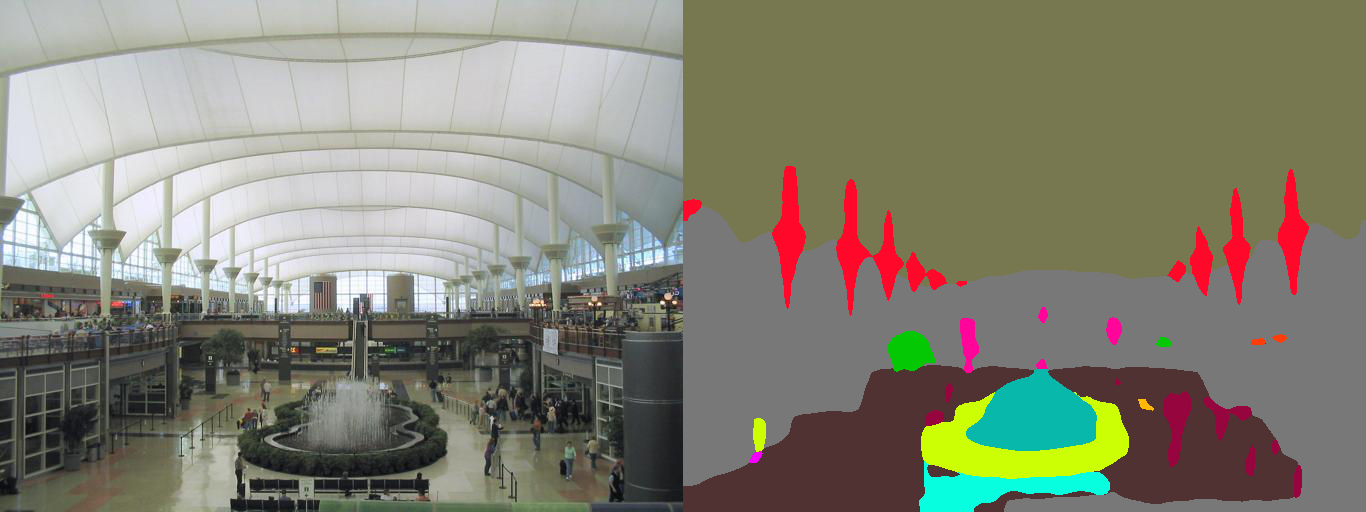

In [134]:
visualize_result(img, pred)

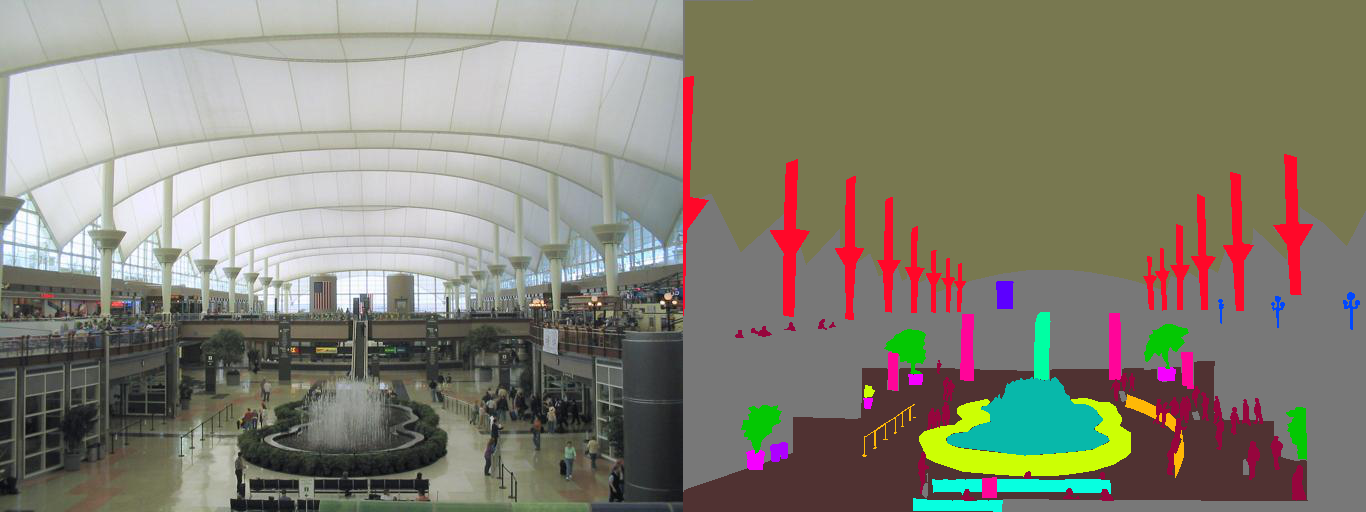

In [138]:
visualize_result(img, anno)

In [144]:
np.unique(anno)

array([  0,   3,   4,   5,  12,  17,  31,  32,  42,  43,  87,  96, 104,
       125, 138, 149], dtype=uint8)

In [145]:
np.unique(pred)

array([  0,   3,   4,   5,  12,  17,  31,  32,  38,  42,  43, 104, 125])

In [147]:
# np.unique(np.append(np.unique(anno), np.unique(pred)))

In [152]:
print(acc)

90.93313963631054
